In [64]:
from modules.parts_top_view_AE import Autoencoder
from modules.encodings_dataset import EncodingsDataset
from modules.module_utils import Flatten
from modules.module_utils import DeFlatten
from torchvision import models

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

import os
import pickle
import numpy as np

from PIL import Image

from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn = torch.load('../artifacts/models/cnn_latent_noise_cpu_model_b64_w2_e140.pt')
cnn = cnn.to(device)
# decoder = torch.load('Models/s_gpu_model_b64_w2_e50.pt').decoder

model = Autoencoder()
model = torch.load('../artifacts/models/ae_latent_noise_cpu_model_b64_w2_e30.pt')
encoder = model.encoder
decoder = model.decoder

decoder = decoder.to(device)
encoder = encoder.to(device)

In [71]:
device

device(type='cpu')

In [72]:
from torchvision import utils
def get_results_img(x, nrow=8, padding=5, cnn = True):
# def get_results_img(x, nrow=8, padding=5):
    if cnn:
        return utils.make_grid(
            x.view(-1, *(3, 256, 306)),
            nrow=nrow, padding=padding).permute(1,2,0)
    else:
        return utils.make_grid(
            x.view(-1, *(3, 128, 128)),
            nrow=nrow, padding=padding).permute(1,2,0)


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
inv_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

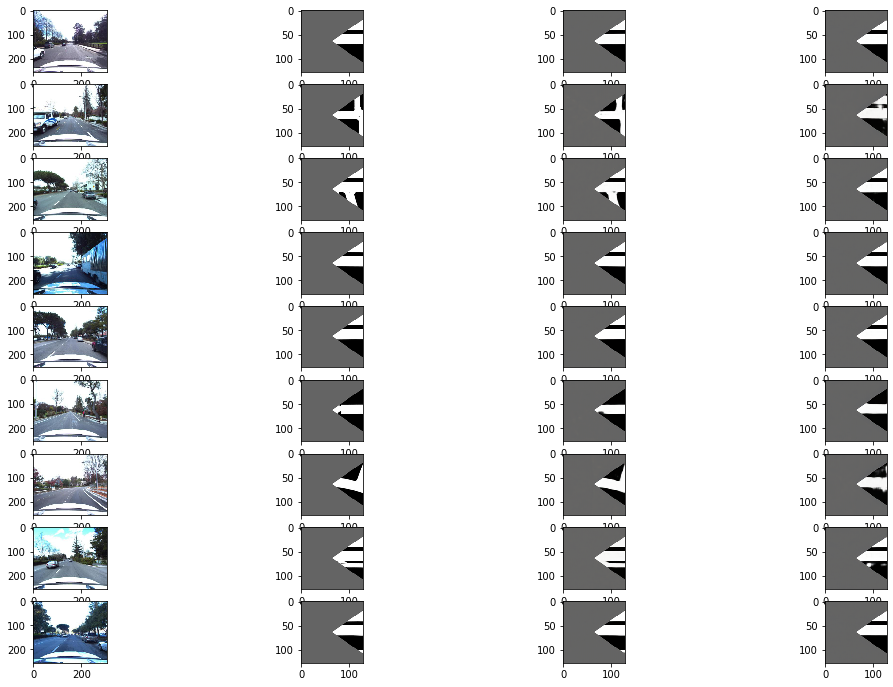

In [80]:

scene_list = [118, 116, 115, 106, 120, 116, 110, 114, 123]
section_list = [102, 94, 100, 19, 114, 113, 125, 70, 96]

f, axis = plt.subplots(len(scene_list), 4)
f.set_figheight(12)
f.set_figwidth(18)

i = 0
for (scene, section) in list(zip(scene_list, section_list)):
    camera_image_true = Image.open(f'../artifacts/data/camera_data/val/{scene}_{section}_front.jpeg').convert('RGB')
    camera_image = torchvision.transforms.functional.to_tensor(camera_image_true) 
    #         camera_image = camera_image.view(1, *camera_image.shape)
    camera_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(camera_image)
    camera_image = camera_image.view(1, *camera_image.shape)
    camera_image = camera_image.to(device)

    parts_image_true = Image.open(f'../artifacts/data/parts_data_2/val/{scene}_{section}_front.png').convert('RGB')
    parts_image = torchvision.transforms.functional.to_tensor(parts_image_true)
    parts_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(parts_image)
    #         parts_image = parts_image.view(1, *parts_image.shape)
    parts_image = parts_image.view(1, *parts_image.shape)
    parts_image = parts_image.to(device)

    with torch.no_grad():
        code = encoder(parts_image)
        code = code.to(device)
        decoder_output = decoder(code)

        out_normalized_ae = torch.clamp(
            get_results_img(
                    torch.stack([inv_normalize(img1.detach()) for img1 in decoder_output]), cnn=False
                ),
                0, 
                1
            )
    #     plt.figure(figsize = (18, 18))
    #     plt.imshow(out_normalized.cpu().detach())

        code = cnn(camera_image)
        code = code.to(device)
        decoder_output = decoder(code)

        out_normalized_cnn = torch.clamp(
            get_results_img(
                    torch.stack([inv_normalize(img1.detach()) for img1 in decoder_output]), cnn=False
                ),
                0, 
                1
            )
    #     plt.figure(figsize = (18, 18))
    #     plt.imshow(out_normalized.cpu().detach())

    axis[i, 0].imshow(camera_image_true)
    axis[i, 1].imshow(parts_image_true)
    axis[i, 2].imshow(out_normalized_ae)
    axis[i, 3].imshow(out_normalized_cnn)
    
    i += 1



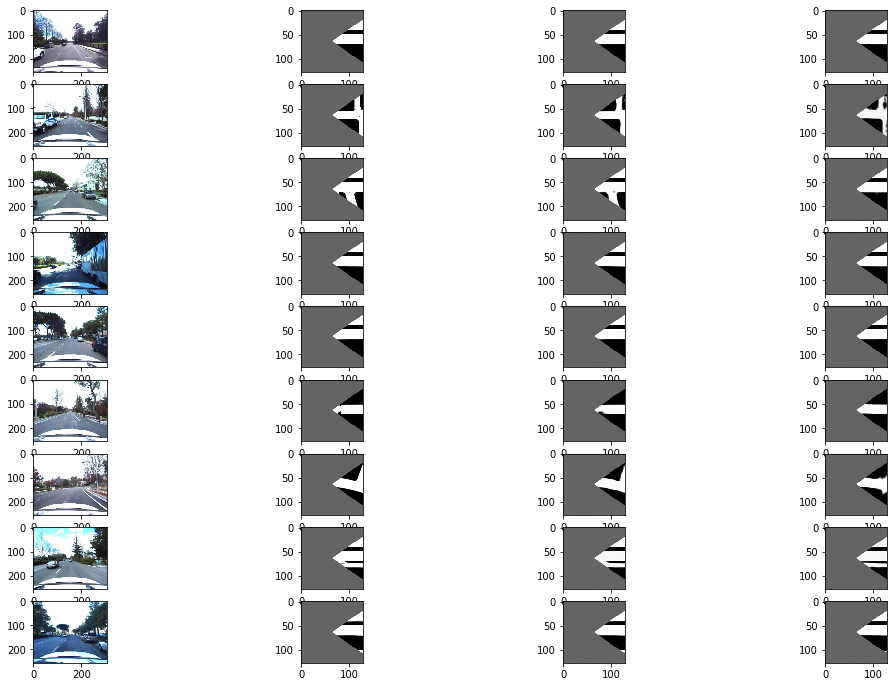

In [86]:
scene_list = [118, 116, 115, 106, 120, 116, 110, 114, 123]
section_list = [102, 94, 100, 19, 114, 113, 125, 70, 96]

f, axis = plt.subplots(len(scene_list), 4)
f.set_figheight(12)
f.set_figwidth(18)

i = 0
for (scene, section) in list(zip(scene_list, section_list)):
    camera_image_true = Image.open(f'../artifacts/data/camera_data/val/{scene}_{section}_front.jpeg').convert('RGB')
    camera_image = torchvision.transforms.functional.to_tensor(camera_image_true) 
    #         camera_image = camera_image.view(1, *camera_image.shape)
    camera_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(camera_image)
    camera_image = camera_image.view(1, *camera_image.shape)
    camera_image = camera_image.to(device)

    parts_image_true = Image.open(f'../artifacts/data/parts_data_2/val/{scene}_{section}_front.png').convert('RGB')
    parts_image = torchvision.transforms.functional.to_tensor(parts_image_true)
    parts_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(parts_image)
    #         parts_image = parts_image.view(1, *parts_image.shape)
    parts_image = parts_image.view(1, *parts_image.shape)
    parts_image = parts_image.to(device)

    with torch.no_grad():
        code = encoder(parts_image)
        code = code.to(device)
        decoder_output = decoder(code)

        out_normalized_ae = torch.clamp(
            get_results_img(
                    torch.stack([inv_normalize(img1.detach()) for img1 in decoder_output]), cnn=False
                ),
                0, 
                1
            )
    #     plt.figure(figsize = (18, 18))
    #     plt.imshow(out_normalized.cpu().detach())

        code = cnn(camera_image)
        code = code.to(device)
        decoder_output = decoder(code)

        out_normalized_cnn = torch.clamp(
            get_results_img(
                    torch.stack([inv_normalize(img1.detach()) for img1 in decoder_output]), cnn=False
                ),
                0, 
                1
            )
    #     plt.figure(figsize = (18, 18))
    #     plt.imshow(out_normalized.cpu().detach())

    axis[i, 0].imshow(camera_image_true)
    axis[i, 1].imshow(parts_image_true)
    axis[i, 2].imshow(out_normalized_ae)
    axis[i, 3].imshow(out_normalized_cnn)
    
    i += 1